## Imports

In [1]:
import math
import numpy as np
import scipy
from scipy import linalg
import scipy.integrate as integ
import scipy.stats as stats
import numpy as np
import astropy.units as u
# import glue 
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.optimize import minimize

In [2]:
# glue.qglue()
matplotlib inline

SyntaxError: invalid syntax (<ipython-input-2-16dff8742d8d>, line 2)

### Choose parameters for Earth or Mars

###############FOR EARTH########################

In [3]:
KT_TNT_EQUIV = 4.185e12
MEAN_IMPACT_VELOCITY = 16700. # EARTH

def grav(alt):
    G = 6.6726e-11    #N-m2/kg2
    M = 5.97237e24      #kg Mass of Earth
    mean_rad = 6371000.0
        
    return G * M / (mean_rad + alt) ** 2

def atm_roh(alt):
    p0_earth = 1.29
    scale_height_earth = 7160.0

    return p0_earth * np.exp(-alt / scale_height_earth)

def new_alt(alt, angle, dt, v):
    dh = np.sin(angle) * dt * v
    return alt - dh

def rad2mass(rad, pm):
    return 4. / 3. * math.pi * (rad)**3 * pm

###############FOR MARS########################

In [4]:
KT_TNT_EQUIV = 4.185e12
MEAN_IMPACT_VELOCITY = 11600 #8750. # MARS

def grav(alt):
    G = 6.6726e-11    #N-m2/kg2
    M = 0.64171e24      #kg Mass of Mars
    mean_rad = 3396200.0
        
    return G * M / (mean_rad + alt) ** 2

def atm_roh(alt):
    p0_mars = 0.020
    scale_height_mars = 10800.0

    return p0_mars * np.exp(-alt / scale_height_mars)
#     if alt>7000:
#         Temp =  -23.4 - 0.00222 * alt  #celcius
#     else: # if alt< 7000:
#         Temp =  -31 - 0.000998 * alt  #celcius
    
#     pressure = 0.699 * np.exp(-0.00009 * alt)

#     return pressure / (0.1921 * (Temp + 273.1))  # density 

def new_alt(alt, angle, dt, v):
    dh = np.sin(angle) * dt * v
    return alt - dh

def rad2mass(rad, pm):
    return 4. / 3. * math.pi * (rad)**3 * pm

In [5]:
def mars_height_equivalent(alt):
    
    p0_earth = 1.29
    scale_height_earth = 7160.0
    p0_mars = 0.020
    scale_height_mars = 10800.0
    
    
    density_earth = p0_earth * np.exp(-alt / scale_height_earth)
    alt_mars = -np.log(density_earth / p0_mars) * scale_height_mars
    
    return alt_mars

print(mars_height_equivalent(65000.))

53044.70832037153


### ablation and drag function definitions

In [6]:
def ablation_fun(v0, slope, r0, pm, yield_str, ground=0.):
    ## assumptions:
    ### Drag coefficient
    cd = 1.3
    
    ### Ablation coefficient
    sigma = 2.5e-8 # sec2/m2
    
    ## Start modelling from alt0 (~space)
    alt0 = 200000.0
    
    ## bulk strength equation from collins et al. 2005
    #yield_str = pow(10, 2.107+0.0624*pow(pm, 0.5))

    ## initiate breakup altitudes
    z_break = 0.
    z_ab = 0.
    z_b = 0.

    ## define common drag/ablation equation parameters
    ### constant wrt height for velocity
    kv = 3/8. * cd / pm 
    
    ### constant wrt height for radius
    kr = 1./8 * sigma * cd / pm 

    # I = 4.07 * cd * H * yield_str / (pm * d * v0**2 * sin(angle))
    # z_break = - H * (log(yield_str / (po * v0**2)) + 1.308 - 0.314 * I - 1.303 * np.sqrt(1 - I))
    
    ## mass for a sphere from volume and density
    m = 4. / 3. * math.pi * (r0)**3 * pm
    
    ## energy given as kinetic energy
    energy_0 = 0.5 * m * v0**2
    
    ## integration height range to be considered
    alt_range = [alt0, z_break]
    calc_alts=np.r_[alt0:ground:-100]
    
    ## parameters to be passed to integration:
    ### initialisation of state before hitting the atmosphere 
    ### [initial velocity, initial radius, initial energy, incoming angle]
    s_angle = np.sin(slope * u.deg)
    X = np.array([v0, r0,  energy_0, s_angle])
    X_all = np.array([v0, r0,  energy_0, s_angle, alt0])

    ### constants and meteoroid density
    param = [kv, kr, pm]
    
    ## start integration. Stop when hits ground, when smaller than 1 mm diam or reach breakup altitude
    i = 1

    while i<len(calc_alts) and X[1]>5e-4 and calc_alts[i] > z_break:    

        ode_out = scipy.integrate.odeint(integrals_abl, X, [calc_alts[i-1], calc_alts[i]],  args = (param,)) 
        
        X = ode_out[1]

        ## calculate head pressure body is exerted to 
        z_test = atm_roh(calc_alts[i]) * X[0]**2

        ## test if the bulk strength of body is exceeded by head pressure. 
        ## set z_break to current altitude 
        if z_test>=yield_str:
            z_break = (calc_alts[i-1]+calc_alts[i])/2.0
        elif X[1] < 5e-4:
            z_ab = calc_alts[i]
        
        save_row = np.hstack((X, calc_alts[i]))
        X_all = np.vstack((X_all, save_row))
                    
        i+= 1
        
    ## final state pulled from integration
    [v, r, energy, s_angle] = X
    slope = np.arcsin(s_angle) * u.rad
    ## mass for a sphere from volume and density
    m = 4. / 3. * math.pi * (r)**3 * pm


    return [v,                            # velocity
           r,                            # radius
           energy,                       # final energy
           slope.to(u.degree),                        # final flight angle
           z_break,                      # bbreakup altitude
           None,#energy / energy_0,            # final / initial energy
           None,#v / v0,                       # final / initial velocity
           None,#r / r0,                    # final / initial diametre
           m,
           0.5 * m * v**2,
           X_all]


In [7]:
## define the function to integrate wrt height
def integrals_abl(X, h, param): 
    [kv, kr, pm] = param
    g = grav(h)
    [v, rad, energy, s_angle] = X

    m = rad2mass(rad, pm)

    Xdot=[0., 0., 0., 0.] 
    
    #dv/dh
    Xdot[0] = kv * atm_roh(h) * v / (rad * s_angle) - g / v
    #dr/dh
    Xdot[1] = kr * atm_roh(h) * v**2 / (s_angle)
    #dE/dh
    Xdot[2] = math.pi * pm * (2 * rad**2 * v**2 * Xdot[1] + 4/3. * rad**3 * v * Xdot[0]) #v**2 * m * v * Xdot[0]    
    #d_angle/dh
    Xdot[3] = -g / v**2 * (1 - s_angle**2) / s_angle

    return Xdot 

In [8]:
## other useful conversion functions

def energy_t_TNT_to_diameter(energy_kT_TNT, density):
    mass = energy_t_TNT_to_mass(energy_kT_TNT)
    volume = mass / density
    diameter = (3. / 4. * volume / math.pi)**(1./3.) * 2
    return diameter


def energy_t_TNT_to_mass(energy_kT_TNT):
    energy_J = energy_kT_TNT * KT_TNT_EQUIV
    mass = energy_J * 2 / MEAN_IMPACT_VELOCITY**2
    return mass

## define the crater scaling from diameter to energy from Teanby et al. 2011
def teanby_2011_eq_1(D, estimate='nominal'):
    a = 8.8e-3
    b = 0.32
    if estimate=='nominal':
        pass
    elif estimate=='hi':
        a += -3.5e-3
        b += -0.01
    elif estimate=='lo':
        a += 2.6e-3
        b += 0.01
    else:
        raise ValueError('estimate')
    
    E = (D/a)**(1/b)
    return E/KT_TNT_EQUIV

#### Functions for optimisation of diameter for a given crater size

In [49]:

def min_fun(r, energy, v0, slope, density, strength):
    """function to minimise is simply difference between impact energy calculated 
    and impact energy required to create your crater size"""
    out = ablation_fun(v0, slope, r[0], density, strength)
    energy2 = out[9] / KT_TNT_EQUIV
    
    return abs(energy2 - energy)/energy

def opt_impactor_rad(v0, slope, density, yeild_str, D):
    """ uses min_fun to determine optimum radius required to give your desired crater diameter D"""
    bodies = []
    required_mass = []
    required_energy = []
    impactor_final_d = []
    
    for estimate in ['nominal','hi','lo']:
        crater_diameter = D
        impactor_energy = teanby_2011_eq_1(crater_diameter,estimate=estimate)
        impactor_mass = energy_t_TNT_to_mass(impactor_energy)
        impactor_radius = energy_t_TNT_to_diameter(impactor_energy, density) / 2.
        
        args = (impactor_energy , v0, slope, density, yeild_str)

        min_out = scipy.optimize.root(min_fun, [0.5],args=args )#, method='L-BFGS-B',args=args, bounds=((0,1),), options={'maxiter':50},tol=1e-7)
        r = min_out.x 
        m = 4. / 3. * math.pi * (r[0])**3 * density
        E0 = (0.5 * rad2mass(r[0], density)*v0**2 /KT_TNT_EQUIV)
        
        out = ablation_fun(v0, slope, r[0], density, yeild_str)
    
        if out[4]>0:
            print(f" /!\ Warning, for the given body strength, the {estimate} required impactor would break up at {out[4]} m altitude, and not make a crater on the ground!\n Try changing body strengths")
        
        else:
            print(f'===============\n{estimate} estimate: {crater_diameter:.1f} m crater on Mars \n requires an impact energy of {impactor_energy:.3e} kt TNT\n This corresponds to an impactor mass at ground level of {impactor_mass:.2f} kg \n This corresponds to an impactor radius of {impactor_radius:.2f} m')
            print('\n Now we will look at what size body this would correspond to at the top of the atmosphere')

            print(f" incoming body parameters: \n  radius: {r[0]:.2f} m, \n  initial mass: {m:.2f},\n  initial velocity (given): {v0:.0f} m/s,\n  initial energy: {E0:.3e},\n\n  which would have a final impact velocity of {out[0]:.0f} m/s, \n  and final impact energy of {out[9]/KT_TNT_EQUIV:.3e}\n")
        
        


defining a class for impacting meteoroid bodies that allows us to query mass/radius/diameter


## have a play with numbers

In [51]:
plt.close()
print("select below from: \n\ninitial velocity (v0) - m/s, \nentry angle from horizontal - degrees, \nimpactor density -kg/m3, \nimpactor bulk strength - MPa, \ncrater diameter to compare to - m")
print("\nThis optimisation may take a few seconds to run, be patient")
def impactor_size_from_craterD(v0, slope, density, bulk_strength, D):
    bulk_strength *= 1e6

    opt_impactor_rad(v0, slope, density, bulk_strength, D)

interact(impactor_size_from_craterD, v0=(11000.,12200., 200.), slope=[10, 30, 45, 60, 90], density=[2200, 3000, 3500], bulk_strength=[0.1, 1, 10, 100], D=(0.5, 50, 1))


select below from: 

initial velocity (v0) - m/s, 
entry angle from horizontal - degrees, 
impactor density -kg/m3, 
impactor bulk strength - MPa, 
crater diameter to compare to - m

This optimisation may take a few seconds to run, be patient


interactive(children=(FloatSlider(value=11600.0, description='v0', max=12200.0, min=11000.0, step=200.0), Drop…

<function __main__.impactor_size_from_craterD(v0, slope, density, bulk_strength, D)>

### interactive energies and diameters for your choice of entry body diametre

In [61]:
plt.close()
print("select below from: ")
print("v0      - initial velocity            - m/s")
print("slope   - entry angle from horizontal - degrees, ")
print("density of incoming body              - kg/m3, ")
print("diametre of incoming body             - m, ")
print("bulk strength of incoming body        - MPa")
def impactor_rad(v0, slope, density, diametre, bulk_strength):
    bulk_strength *= 1e6

    r0 = diametre/2. 
    m0 = 4. / 3. * math.pi * (r0)**3 * density
   
    out = ablation_fun(v0, slope, r0, density, bulk_strength)
    
    ## what crater size?
    a = 8.8e-3
    b = 0.32
    D_nom = (out[2]**b * a) 
    D_hi = out[2]**(b + 0.01) * (a +  2.6e-3) 
    D_lo = out[2]**(b - 0.01) * (a - 3.5e-3) 
    impact_diam = out[1] *2

    print(f"entry body radius = {r0}, diameter={diametre}")
    print(f"entry velocity={v0/1000.:.2f} km/s")
    print(f"entry diametre={diametre:.2f} m")
    print(f"entry mass={m0:.2f}")
    print(f"entry energy={0.5 * m0 * v0**2:.2e} J   or    {0.5 * m0 * v0**2 /KT_TNT_EQUIV:.2e} ktTNT")
    print(f"\nimpact velocity={out[0]/1000.:.2f} km/s")
    print(f"impact mass={out[8]:.2f} kg")
    print(f"impact diametre={impact_diam:.2f} m")
    print(f"impact energy={out[2]:.2e} J    or    {out[2] /KT_TNT_EQUIV:.2e} ktTNT")
    print(f"\nimpact flight angle={out[3]:.2f} degrees")
    print(f"breakup altitude={out[4]:.2f} m")
    print(f"\nNominal crater diameter={D_nom:.2f} m")
    print(f"Upper crater diameter={D_hi:.2f} m")
    print(f"Lower crater diameter={D_lo:.2f} m")
        
    ## use drag only, no ablation:
#     out = drag_fun(v0, slope, r, density, strength)

interact(impactor_rad, v0=(11000.,12200., 200.), slope=[10, 30, 45, 60, 90], density=[2200, 3000, 3500], diametre=(0.01, .6, 0.01), bulk_strength=[0.1, 1, 10, 100])

select below from: 
v0      - initial velocity     - m/s
slope   - entry angle from horizontal - degrees, 
density of incoming body       - kg/m3, 
diametre of incoming body      - m, 
bulk strength of incoming body - MPa


interactive(children=(FloatSlider(value=11600.0, description='v0', max=12200.0, min=11000.0, step=200.0), Drop…

<function __main__.impactor_rad(v0, slope, density, diametre, bulk_strength)>

### interactive energies and diameters for your choice of entry body mass

In [70]:
plt.close()
print("select below from: ")
print("v0      - initial velocity            - m/s")
print("slope   - entry angle from horizontal - degrees, ")
print("density of incoming body              - kg/m3, ")
print("mass of incoming body                 - kg, ")
print("bulk strength of incoming body        - MPa")

def impactor_mass(v0, slope, density, mass, bulk_strength, D):
   ## mass for a sphere from volume and density
    r0 = (mass*u.kg / (density*u.kg/u.m**3) * 3./(4. * math.pi))**(1/3.)
    E0 = 0.5 * mass*u.kg * (v0 * u.m /u.s)**2 / KT_TNT_EQUIV
    diametre = r0*2.     

    out = ablation_fun(v0, slope, r0.value, density, bulk_strength)
    
    ## what crater size?
    a = 8.8e-3
    b = 0.32
    D_nom = (out[2]**b * a) 
    D_hi = out[2]**(b + 0.01) * (a +  2.6e-3) 
    D_lo = out[2]**(b - 0.01) * (a - 3.5e-3) 
    impact_diam = out[1] *2

    print(f"entry body mass = {mass:.2f} kg")
    print(f"entry velocity ={v0/1000.:.2f} km/s")
    print(f"entry diametre ={diametre:.2f}")
    print(f"entry radius = {r0:.2f}, diameter={diametre:.2f}")
    print(f"entry energy = {0.5 * mass * v0**2:.3e} J   or {E0.value:.3e} ktTNT")
    print(f"\nimpact velocity ={out[0]/1000.:.2f} km/s")
    print(f"impact mass = {out[8]:.2f} kg")
    print(f"impact diametre = {impact_diam:.2f} m")
    print(f"impact energy = {out[2]:.3e} J    or    {out[2] /KT_TNT_EQUIV:.3e} ktTNT")
    print(f"\nimpact flight angle = {out[3]:.2f} degrees")
    print(f"breakup altitude = {out[4]:.2f} m")
    print(f"\nNominal crater diameter = {D_nom:.2f} m")
    print(f"Upper crater diameter = {D_hi:.2f} m")
    print(f"Lower crater diameter = {D_lo:.2f} m")
    
interact(impactor_mass, v0=(11000.,12200., 200.), slope=45, density=[3000,3500], mass=1.5, bulk_strength=1e6, D=1.5)

select below from: 
v0      - initial velocity            - m/s
slope   - entry angle from horizontal - degrees, 
density of incoming body              - kg/m3, 
mass of incoming body                 - kg, 
bulk strength of incoming body        - MPa


interactive(children=(FloatSlider(value=11600.0, description='v0', max=12200.0, min=11000.0, step=200.0), IntS…

<function __main__.impactor_mass(v0, slope, density, mass, bulk_strength, D)>

## Plotting stuff

[0.01 0.11 0.21 0.31 0.41 0.51 0.61 0.71 0.81 0.91 1.01 1.11 1.21 1.31
 1.41]


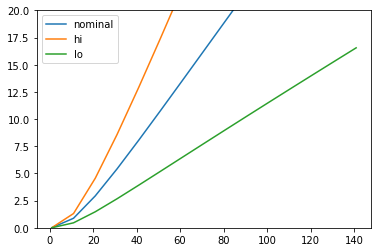

In [71]:
v0 = 11600.
slope = 45.
density = 2800.
bulk_strength = 10e6
diams = np.arange(0.01, 1.5, 0.1)
entry_mass = []
end_diams = []
end_mass = []
print(diams)
diam_to_craterD = np.zeros((3, len(diams)))
for i in range(len(diams)):
    diametre = diams[i]
    r0 = diametre/2.        
    out = ablation_fun(v0, slope, r0, density, bulk_strength)
    
    ## what crater size?
    a = 8.8e-3
    b = 0.32
    D_nom = (out[2]**b * a) 
    D_hi = out[2]**(b + 0.01) * (a +  2.6e-3) 
    D_lo = out[2]**(b - 0.01) * (a - 3.5e-3) 
    impact_diam = out[1] *2
   
    diam_to_craterD[:, i] = [D_nom, D_hi, D_lo]
    end_diams.append(impact_diam)
    entry_mass.append(density * 4./3 * math.pi * r0**3)
    end_mass.append(density * 4./3 * math.pi * (impact_diam/2)**3)

plt.plot(diams*100, diam_to_craterD[0, :], label='nominal' )
plt.plot(diams*100, diam_to_craterD[1, :], label='hi' )
plt.plot(diams*100, diam_to_craterD[2, :], label='lo' )
plt.ylim(0,20)
plt.legend()
# plt.plot(entry_mass, diam_to_craterD[0, :], label='nominal' )
# plt.plot(entry_mass, diam_to_craterD[1, :], label='hi' )
# plt.plot(entry_mass, diam_to_craterD[2, :], label='lo' )
# plt.legend()